# Digging Into Economic Data: What Signals a Recession?

Let's dive into the economic data we've gathered and see what stories it tells us about past recessions. We'll look at patterns, spot interesting relationships, and get a feel for how different economic indicators behave when the economy takes a downturn.

In [1]:
# Initialize notebook with all necessary imports and setup
from notebook_utils import init_notebook
init_notebook()

# Import additional libraries we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Import specific functions from notebook_utils
from notebook_utils import load_data, display_data_info, save_figure

# Import econ_downturn functions directly
from econ_downturn import (
    plot_indicator_with_recessions, plot_correlation_matrix,
    plot_recession_correlations
)

Initializing notebook environment...
✓ Added c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\src to Python path
✓ econ_downturn package imported successfully
✓ Notebook environment configured
✓ Environment variables loaded

Available data paths:
  fred_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred
  nber_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\nber
  processed_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed
  fred_all_indicators: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred\all_indicators.csv
  nber_recession_indicator: c:\Users\Admin\e

## Getting Our Data Ready

First, our economic data will be loaded. For the purpose of this project, we have used macroeconomic indicators from FRED and UMICH and recesson dates from NBER. The recession rates in particular are key for the binary classification of our MDA model in future steps. This NBER data distinguishes the positive class (recessionary) vs. the negative class (non-recessionary). For the purpose of this section, the blended dataset is simply pulled from the notebook_utils utility module.

1. NBER is used to flag recessionary vs. non-recessionary periods.

2. FRED and UMICH data is used for macroeconomic indicators.

3. These three datasets are merged together to retrieve our full initial dataset.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=True)

Loading cached merged data from c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\merged_data.csv
2025-07-06 13:20:24,586 - econ_downturn.data.data_loader - INFO - Loaded merged data with shape: (15657, 13)
Loaded merged data with shape: (15657, 13)


## What Does Our Dataset Look Like?

In this section, we examine the basic structure and quality of the dataset using our display_data_info() function. The purpose of this function is diagnostic, and asseses whether our data is ready for analysis and modeling. This step is targeted at identifying initial data quality issues such as missing values or irregular time coverage. These need to be addressed before modeling.

The function's purpose:

1. Checks whether the dataset is empty (or null).

2. Reports the time range covered by the dataset. It assumes a time-based index.

3. Generates a descriptive statistics summary for each feature including mean, standard deviation, and range.

4. Calculates the number and % of missing values in each column, then lists in descending order of missing quantity.

In [3]:
# Display information about the dataset
display_data_info(merged_data)

Dataset Information:
Time Range: 1970-01-01 00:00:00 to 2024-05-31 00:00:00
Number of Observations: 15657
Number of Features: 13

Summary Statistics:


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT,INFLATION_EXPECTATION
count,218.000000,653.000000,653.000000,653.000000,11998.000000,2.839000e+03,653.000000,389.000000,653.000000,589.000000,653.000000,589.000000,557.000000
mean,12837.776711,6.110260,158.663954,4.910490,0.868401,3.733381e+05,74.982246,365237.385604,1435.917305,84.583531,0.128637,84.583531,3.590126
std,5217.489014,1.709394,73.783619,3.898737,0.925610,2.450608e+05,22.585732,138188.557313,410.165486,13.111529,0.335054,13.111529,1.625392
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000,0.400000
25%,7760.008000,4.900000,100.100000,1.510000,0.190000,3.010000e+05,51.806000,264067.000000,1176.000000,74.300000,0.000000,74.300000,2.800000
50%,12216.346500,5.800000,159.800000,5.050000,0.830000,3.460000e+05,78.919700,349869.000000,1465.000000,88.200000,0.000000,88.200000,3.000000
75%,16937.626250,7.200000,219.035000,6.890000,1.500000,4.020000e+05,97.606000,443117.000000,1698.000000,94.200000,0.000000,94.200000,3.500000
max,23223.906000,14.800000,313.140000,19.100000,2.910000,6.137000e+06,104.103800,692635.000000,2494.000000,112.000000,1.000000,112.000000,10.400000



Missing Values:


,Missing Values,Percentage
GDP,15439,98.607652
RETAIL_SALES,15268,97.515488
INFLATION_EXPECTATION,15100,96.442486
SENTIMENT,15068,96.238104
CONSUMER_SENTIMENT,15068,96.238104
INDUSTRIAL_PROD,15004,95.829342
FED_FUNDS,15004,95.829342
CPI,15004,95.829342
UNEMPLOYMENT,15004,95.829342
recession,15004,95.829342


## Plotting the Economic Story

This section explores basic time-series behavior of our various macroeconomic indicators by generating line plots over time. Each of these plots will overlay a single economic indicator with officially classified U.S. recessionary periods highlighted in the background. This shading represents NBER's defined recessionary intervals.

Our goal is to visualize how different indicators fluctuate leading up to, during, and after known recessions. For example, we could observe that the unemployment rate peaks right before recessions, or another interest variable drobs shortly at recession onset. These visual patterns help inform the viewer which indicators are useful for predictive modeling.

The logic lays out the following steps:

1. Filters out the recession classification column, as this is the target variable and not a prediction indicator.

2. Uses only the first five indicators for brevity.

3. For each indicator, calls our utility function plot_indicator_with_recessions() to generate a line chart with the indicator value over time, overlay shaded bands to show recessionary periods, and displays the final figure.

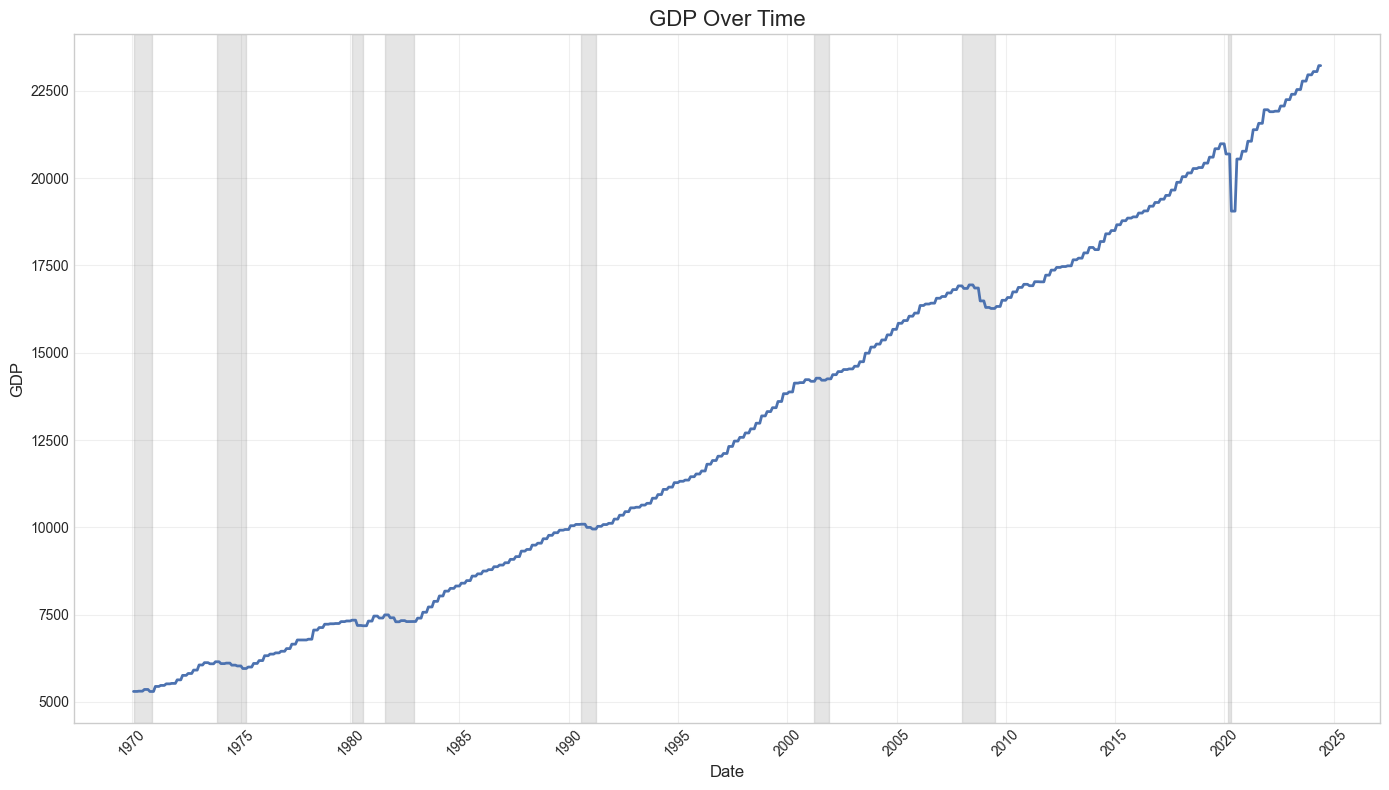

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\gdp_over_time.png


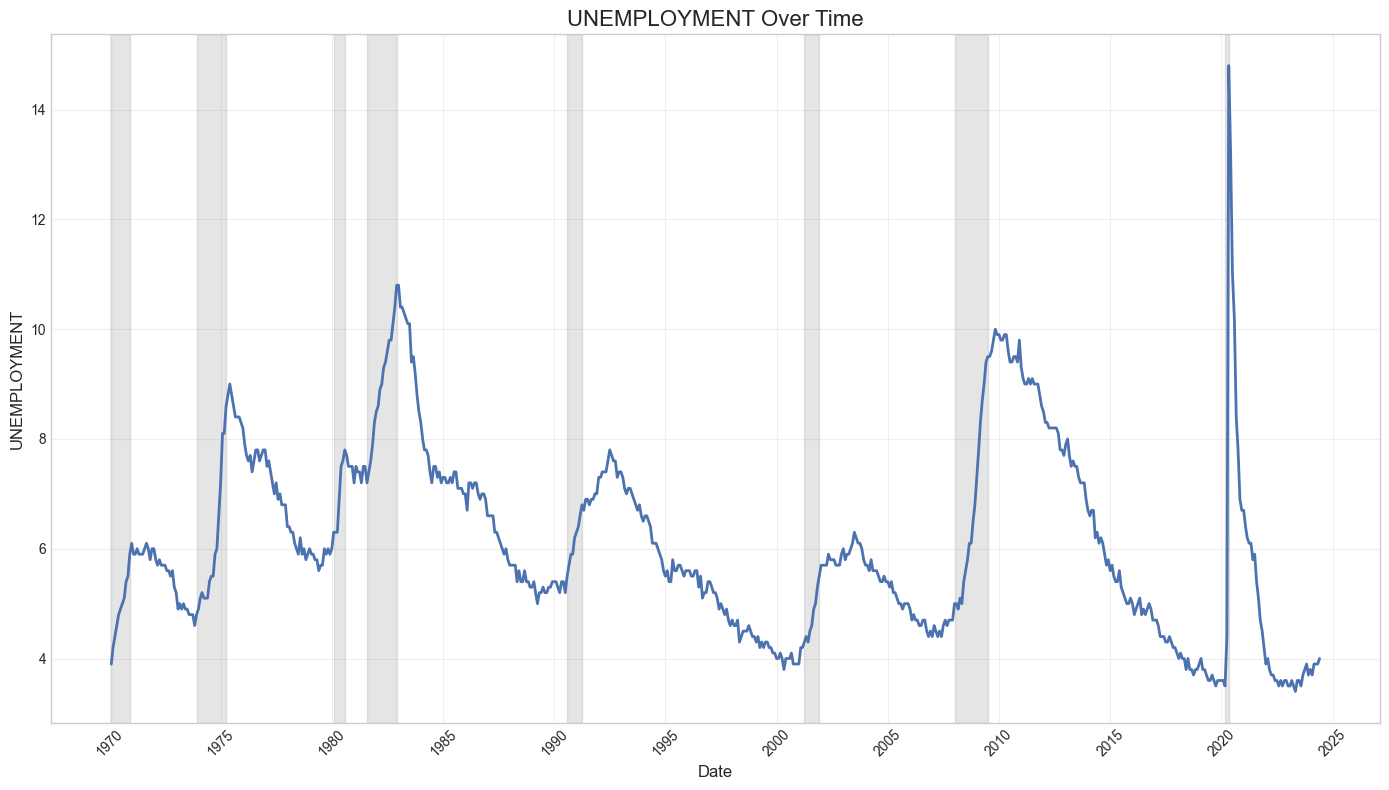

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\unemployment_over_time.png


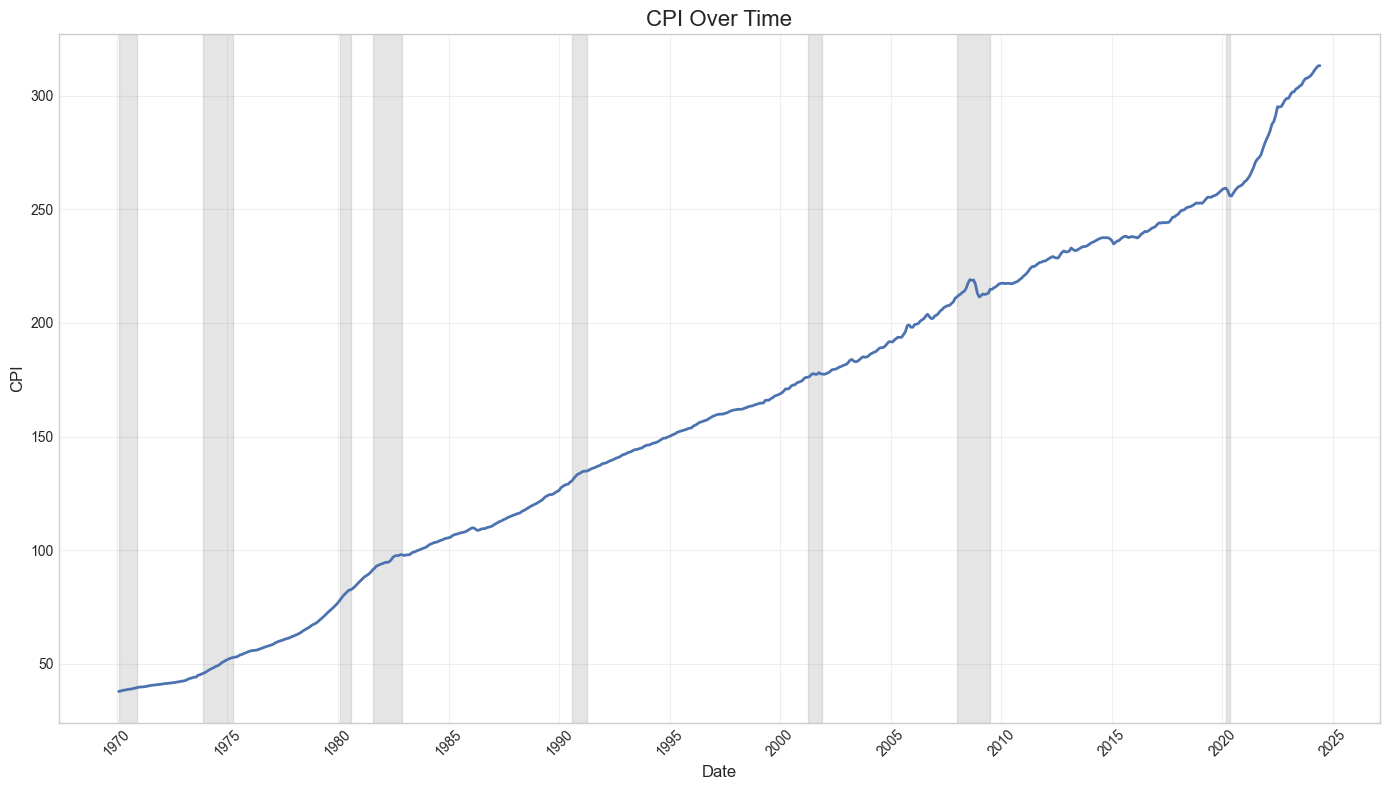

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\cpi_over_time.png


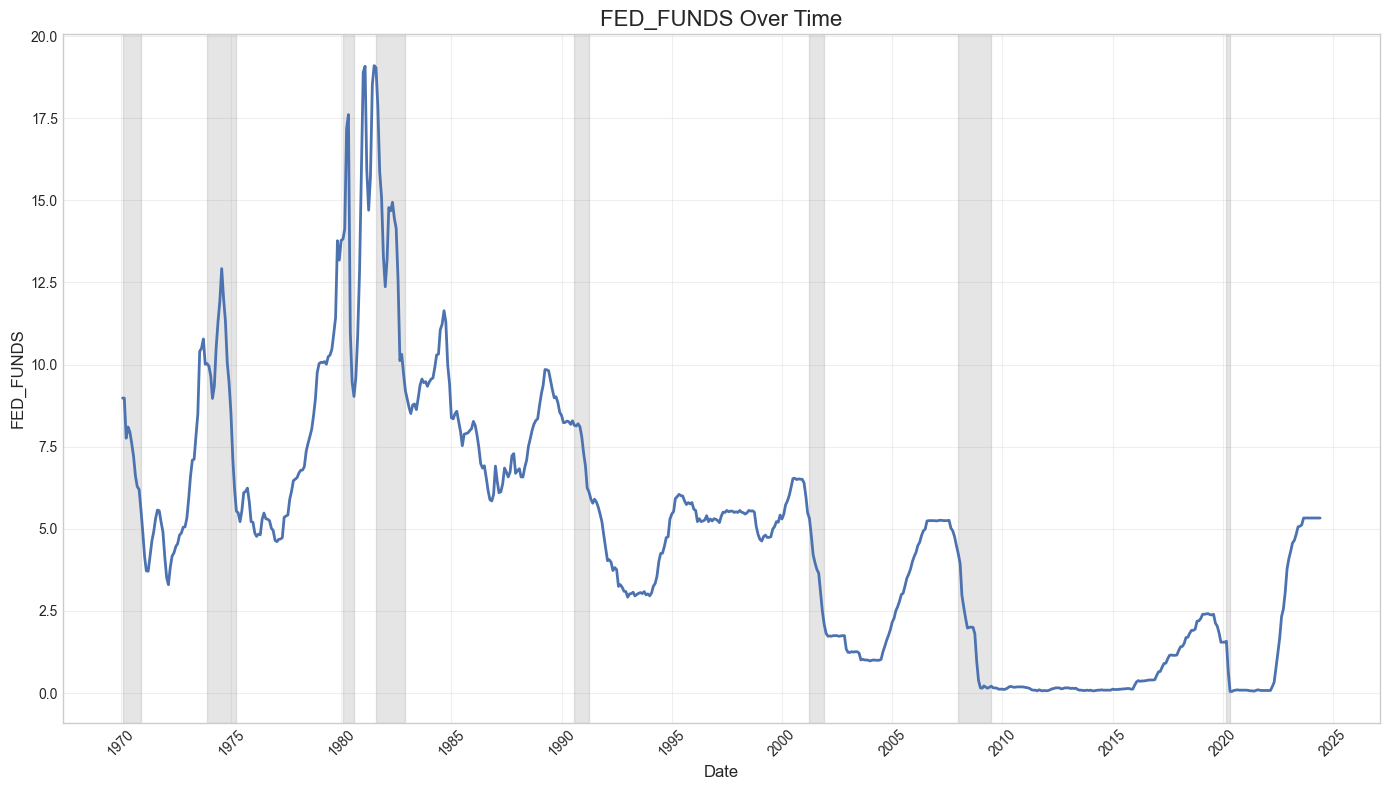

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\fed_funds_over_time.png


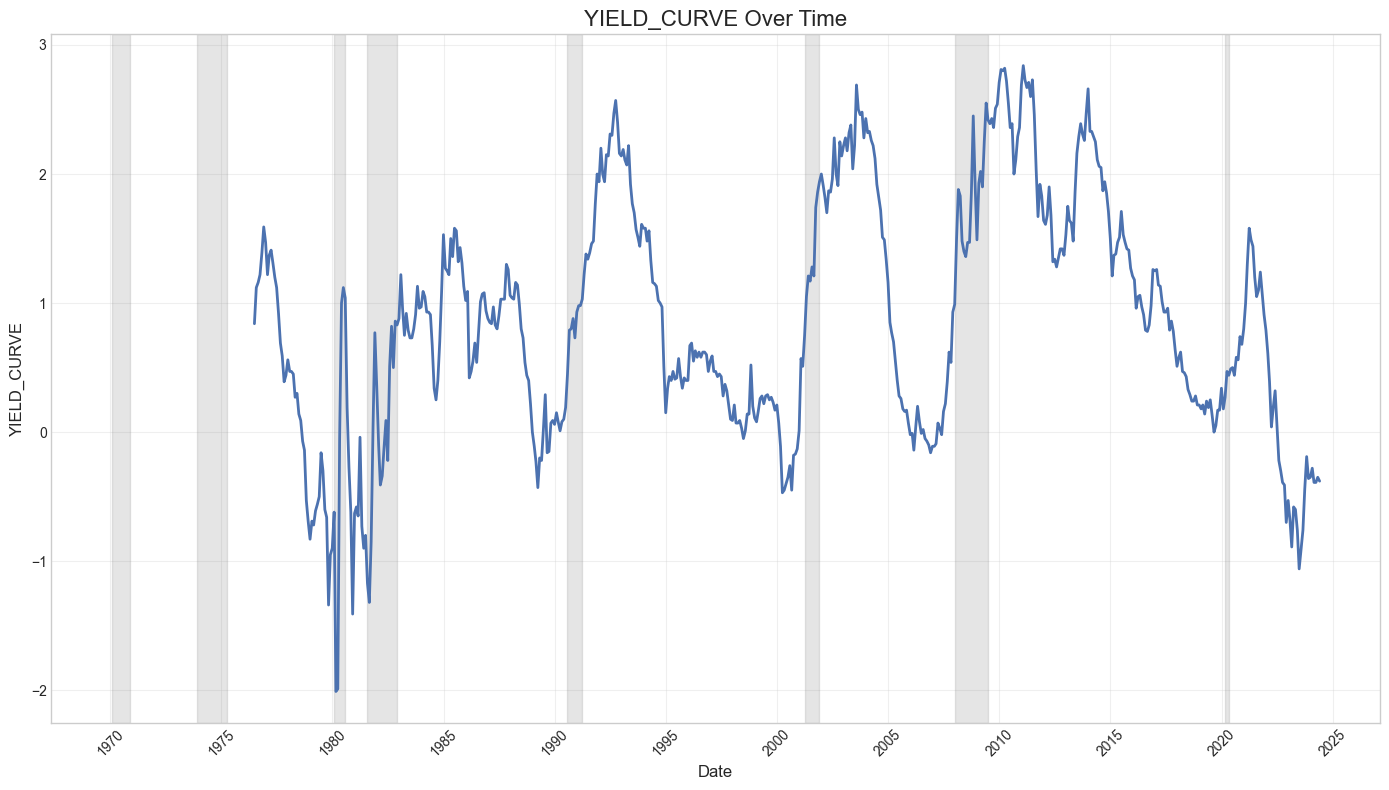

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\yield_curve_over_time.png


In [4]:
if merged_data is not None and 'recession' in merged_data.columns:
    # Plot key economic indicators
    indicators_to_plot = [
        col for col in merged_data.columns if col != 'recession'
    ]
    
    for indicator in indicators_to_plot[:5]:  # Plot first 5 indicators for brevity
        if indicator in merged_data.columns:
            fig = plot_indicator_with_recessions(
                merged_data, 
                indicator,
                title=f"{indicator} Over Time"
            )
            plt.show()
            
            # Save the figure
            save_figure(fig, f"{indicator.lower()}_over_time.png")

## 4. Correlation Analysis

This section is aimed at investigating statistical relationships between macroeconomic indicators, namely with correlation analysis. This is to understand which indicators move together, expanding our knowledge of how our indicator sets interact. This helps us identify basic predictors for our future MDA classification model. There are two visual analyses performed within the code block:


#### 1. Correlation Matrix:
Generates a heatmap of Pearson correlation coefficients among every numeric feature in the dataset. Naturally, this excludes the target variable of "recesssion". Values range from -1 to 1 where:

1a. Checks if the input data is valid before preceeding.

2a. If so, the function calculates the correlation coefficient for each feature compared to the other features.

3a. Returns a colored coded square grid where darker colors indicate stronger correlations, and lighter colors indicate weaker.



#### 2. Recession Correlation Plot (conditional):
Assuming the dataset has a binary recession column (as it should, the fact that it's conditional is simply an effort to error-proof the code), this plot shows the strength of each indicator's correlation with recession occurence. This essentially ranks indicators by their correlation in recessionary periods.

1b. The dataset is checked for a valid binary recession indicator column.

2b. If so, the function calculates the correlation coefficient for each feature compared to the recessionary flag.

3b. Each feature is checked for correlation relevance and included in the final heatmap.

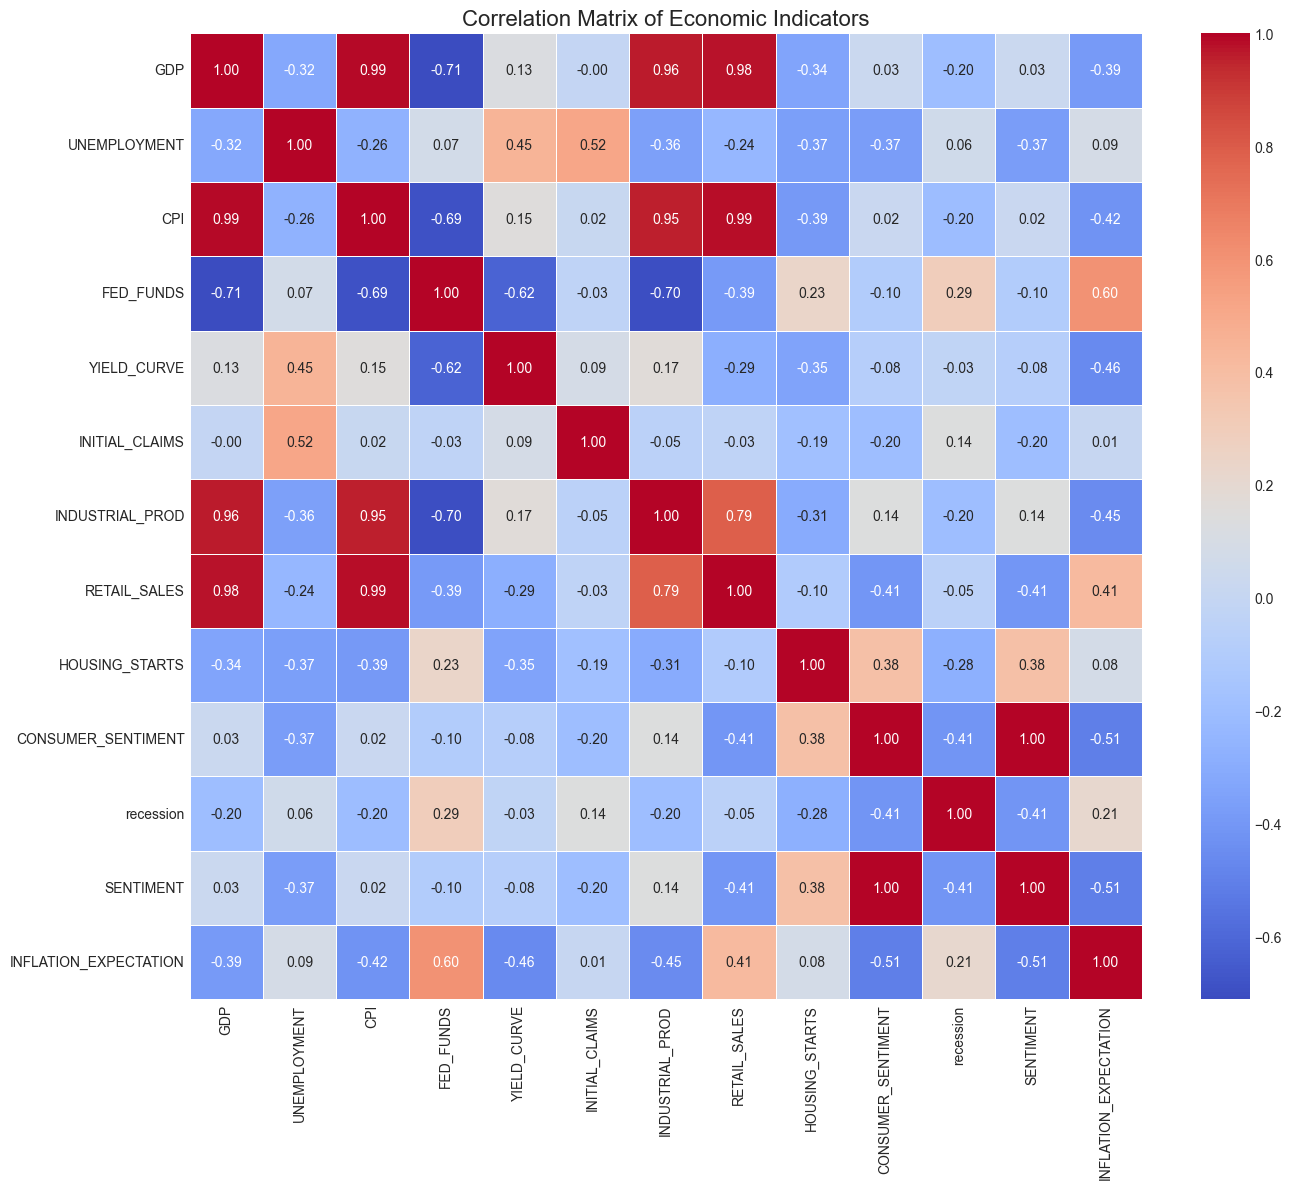

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\correlation_matrix.png


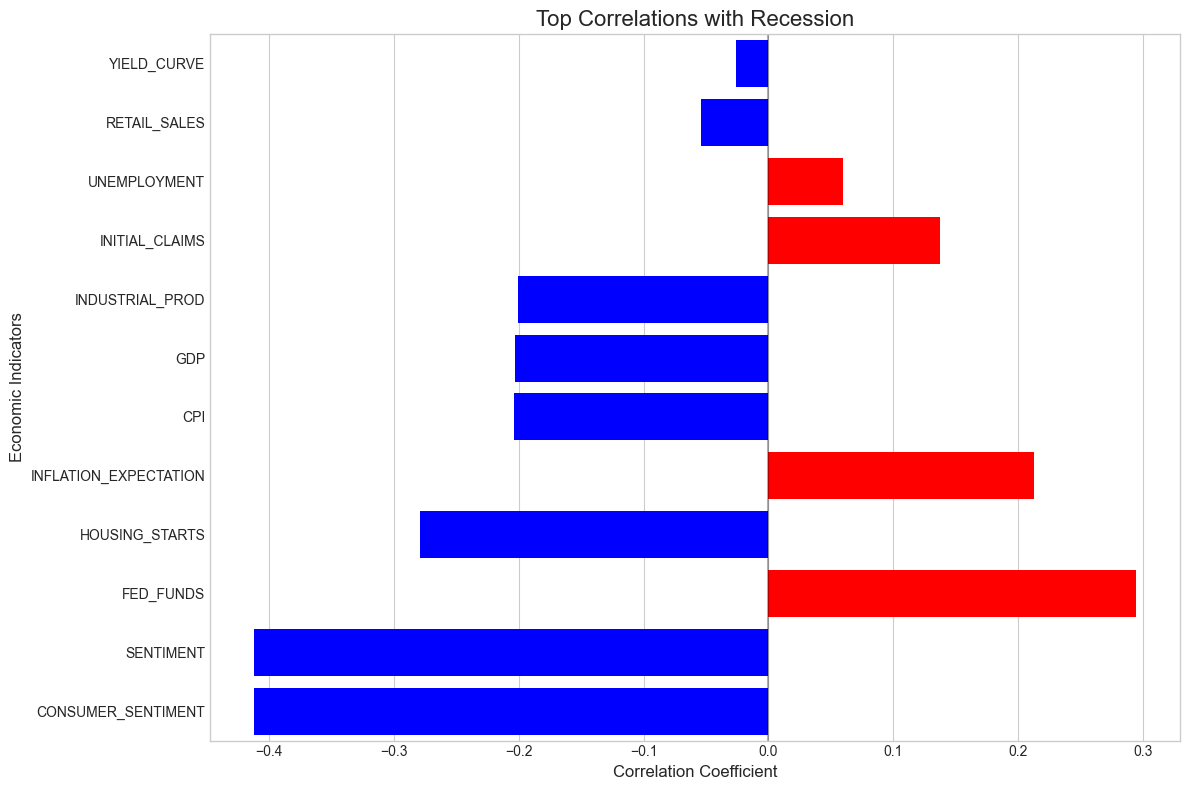

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\recession_correlations.png


In [5]:
if merged_data is not None:
    # Plot correlation matrix
    fig = plot_correlation_matrix(merged_data)
    plt.show()
    save_figure(fig, "correlation_matrix.png")
    
    # If recession indicator is available, show correlations with recession
    if 'recession' in merged_data.columns:
        fig = plot_recession_correlations(merged_data)
        plt.show()
        save_figure(fig, "recession_correlations.png")